In [1]:
import gym
import matplotlib.pyplot as plt
import sys
import numpy
import logging
sys.path.append('/home/maradona/neuron_poker/neuron_poker-master')
sys.path.append('/home/maradona/neuron_poker/neuron_poker-master/tools')
import numpy as np
import pandas as pd
import torch
import time
from collections import namedtuple, deque
from copy import deepcopy, copy
import random

In [2]:
#from gym_env.env import HoldemTable, Action, Stage, PlayerCycle, CommunityData, PlayerShell
from gym_env.env import HoldemTable, Action
from agents.agent_random import Player as RandomPlayer
from agents.agent_consider_equity import Player as EquityPlayer
from agents.agent_autoplay_random import Player as Random_autoplay_Player
from tools.helper import get_config
from tools.helper import init_logger
from tools.helper import flatten

In [3]:
#llença el logging, tant per pantalla com als log files

def logging_funct():

    print("Using default log file")
    logfile = 'default'
    model_name = 'test'
    screenloglevel = logging.INFO
    _ = get_config()
    init_logger(screenlevel=screenloglevel, filename=logfile)
    print(f"Screenloglevel: {screenloglevel}")
    log = logging.getLogger("")
    log.info("Initializing program")

In [4]:
#logging_funct()

In [5]:
def _create_env():
    """Create an environment"""
    env = HoldemTable()
    player = RandomPlayer(name='DQN_0')
    env.add_player(player)
    player = Random_autoplay_Player(name='RANDOM_1')
    env.add_player(player)
    #player = Random_autoplay_Player(name='RANDOM_2')
    #env.add_player(player)
    #player = EquityPlayer(name='EQUITY_3', min_call_equity=.2, min_bet_equity=-.3)
    #env.add_player(player)
    return env

In [6]:
env = _create_env()

In [7]:
state0 = env.reset()   ##Cal inicialitzar-ho per carregar env.observation_space[0] a la xarxa neuronal

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        
        ######################################
        ##Initialitzar paràmetres
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
       
    
    
        #######################################
        ##Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True))
        
        
        
        
        #######################################
        ##Inicialitzar optimitzador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
          

            
            

    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)  # acció del càlcul de Q per a aquesta acció
            no_legals = [x for x in np.arange(env.action_space.n) if x not in [x.value for x in env.legal_moves]]
            for i in no_legals:
                qvals[i] = float('-inf')   #posem a -inf tots els qvals que corresponen a moviments il-legals
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

In [10]:
class DQNAgent:
    
    ###################################################
    ###### Declarar variables        ##################
    def __init__(self, reward_threshold, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32): 
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 #bloc dels últims X episodis dels que es calcularà mitja de recompenses
        self.reward_threshold = reward_threshold
        self.initialize()
    
    
    ###############################################################
    ##### Inicialitzar variables extra que es necessitin###########
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.state0 = env.reset()
        self.total_reward = 0
        self.step_count = 0
        self.last_position = []
        self.epsilons = []
        self.training_loss = []
        self.ilegales = []
               
        
        
        
    #################################################################################
    ###### Prendre nova acció ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = random.choice(self.main_network.actions)
        else:
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1
            
        #prendre 'step' i obtenir nou estat i recompensa. Guardar experiència al buffer
        new_state, reward, done, _ = self.env.step(action)
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
               
        if done:
            if mode == 'train':
                self.last_position.append(new_state[0])
            self.state0 = env.reset()
        return new_state, reward, done, _ 
        
        

    
        
    ##ENTRENAMENT
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
            
            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            env.ilegal = 0
            while gamedone == False:
                #Agents autoplay de l'entorn
                if env._agent_is_autoplay(): #desencadena tot el joc autoplay
                    action = env.current_player.agent_obj.action(env.legal_moves, env.observation, env.info)
                    new_state, reward, gamedone, info = env.step(action)
                    if not gamedone:
                        reward = 0
                #Quan siguin més de 2 jugant he de finalitzaar partida si jo no jugo, o no pillar recompensa
                #Agent
                else:
                    new_state, reward, gamedone, info = self.take_step(self.epsilon, mode='train')
                
                self.total_reward += reward
                
                
                #################################################################################
                ##### Actualitzar la xarxa principal segons la freqüència establerta ############
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                
                
                
                    
                ########################################################################################
                ### Sincronitzar xarxa principal y xarxa objectiu segons la freqüència establerta#####

                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)
                
                                
                if gamedone:  
                    episode += 1
                    self.training_rewards.append(self.total_reward)
                    self.training_loss.append(np.mean(self.update_loss))
                    self.update_loss = []   
                    self.ilegales.append(env.ilegal)
                
                    
                    #######################################################################################
                    ### Calcular la mitjana de recompensa dels últims X episodis, y almacenar#####
                    
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)                   

                    print("\rEpisode {:d} Reward {:d} Mean Rewards {:.2f} Epsilon {} Illegal movements {:d}\t\t"
                          .format(episode, self.total_reward, mean_rewards, self.epsilon, env.ilegal), end="")
                    
                    #######################################################################################
                    ### Comprobar que encara queden episodis, i/o parar si s'ha arribat al límit

                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                        
                    
                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per l'entorn     
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    #################################################################################
                    ###### Actualitzar epsilon segons la velocitat de decaïment fixada########

                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    self.epsilons.append(self.epsilon)
                                      
   

    ####################################          
    #####Càlcul de la pèrdua####
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenim els valors de Q de la xarxa objectiu. El paràmetre detach() 
        #evita que aquests valors actualitzin la xarxa objectiu
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### Calcular equació de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### Càlcul de la pèrdua
        #loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        loss = torch.nn.MSELoss()(qvals, expected_qvals)
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch) # calculem la pèrdua
        loss.backward() # fem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        self.update_loss.append(loss.detach().numpy())

In [11]:
lr = 0.001
BATCH_SIZE = 32
MAX_EPISODES = 5000
BURN_IN = 1000
DNN_UPD = 3
DNN_SYNC = 1000
MEMORY_SIZE = 100000
EPSILON = 1           
EPSILON_DECAY = 0.99   
GAMMA = 0.99   
REWARD_THRESHOLD = 1000000

In [12]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

In [13]:
dqn = NeuralNet(env, learning_rate=lr)

In [14]:
agentDQN = DQNAgent(REWARD_THRESHOLD, env, dqn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)

In [15]:
start = time.time()

In [16]:
agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
               batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...


/home/maradona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272126608/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
/home/maradona/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 87 Reward 208 Mean Rewards 36.71 Epsilon 0.4213342221547681 Illegal movements 1				

/home/maradona/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maradona/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 5000 Reward -293 Mean Rewards 56.47 Epsilon 0.01 Illegal movements 1			movements 0				
Episode limit reached.


In [26]:
file = "/home/maradona/Desktop/data_science/TFM/3/DQNAgent_Trained_Model_Good_001.pth"
torch.save(agentDQN.main_network.state_dict(), file)

In [18]:
end = time.time()
print((end - start) / 3600)

6.500900102655093


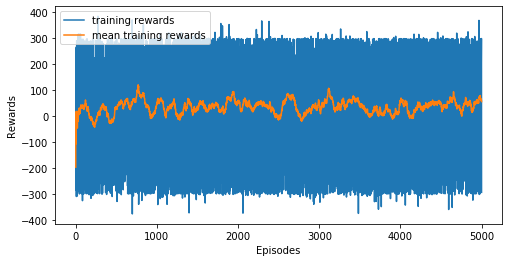

In [27]:
plt.figure(figsize=(8,4))
plt.plot(agentDQN.training_rewards, label='training rewards')
plt.plot(agentDQN.mean_training_rewards, label='mean training rewards')
#plt.axhline(env.spec.reward_threshold, color='r', label="reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

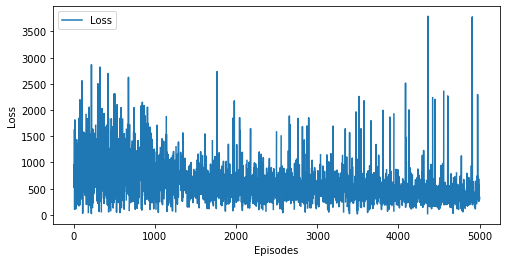

In [28]:
plt.figure(figsize=(8,4))
plt.plot(agentDQN.training_loss, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

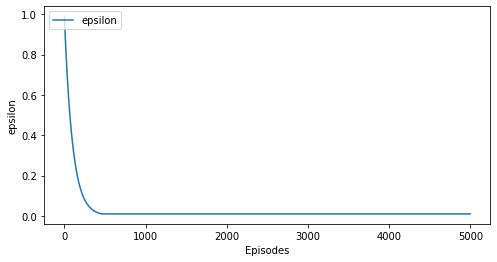

In [29]:
plt.figure(figsize=(8,4))
plt.plot(agentDQN.epsilons, label='epsilon')
plt.xlabel('Episodes')
plt.ylabel('epsilon')
plt.legend(loc="upper left")
plt.show()

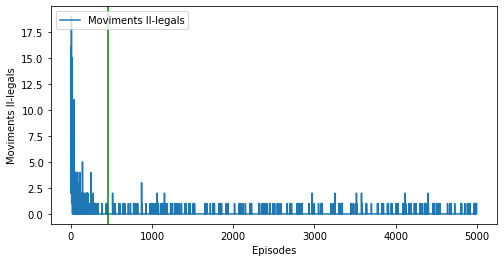

In [30]:
one = agentDQN.epsilons.index(0.01)
plt.figure(figsize=(8,4))
plt.plot(agentDQN.ilegales, label='Moviments Il-legals')
plt.xlabel('Episodes')
plt.ylabel('Moviments Il-legals')
plt.legend(loc="upper left")
plt.axvline(x = one, color = 'g') 
plt.show()

In [31]:
agentDQN.main_network.load_state_dict(torch.load
                                      ('/home/maradona/Desktop/data_science/TFM/3/DQNAgent_Trained_Model_Good_001.pth'))

<All keys matched successfully>

In [32]:
rewards = []
winner = []
stack = []
ilegales = []
rango = 500
for episode in range(rango):
    observation = env.reset()
    total_reward = 0
    t = 0
    env.ilegal = 0
    while True:
        action = agentDQN.main_network.get_action(observation)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t += 1
        if done:
            rewards.append(total_reward)
            ilegales.append(env.ilegal)
            winner.append(env.winner_ix)
            for i in range(len(env.players)):
                if env.players[i].name == 'DQN_0':
                    stack.append(env.players[i].stack)
            break
    print('Episode {}\tReward: {:.2f} \tFinished in {} timesteps\tIlegal movements {}\tStack {}\t Winner {}\n'
          .format(episode, total_reward, t+1, ilegales[episode], stack[episode], winner[episode]), end="")
print("\n\n % partides guanyades: ",winner.count(0)/rango)
print("\n\n mitja de recompenses: ",sum(rewards)/len(rewards))
print("\n\n mitja de $$$$$$$$$$$: ",sum(stack)/len(stack))

Episode 0	Reward: 268.00 	Finished in 141 timesteps	Ilegal movements 1	Stack 200	 Winner 0
Episode 1	Reward: 226.00 	Finished in 150 timesteps	Ilegal movements 3	Stack 200	 Winner 0
Episode 2	Reward: 216.00 	Finished in 76 timesteps	Ilegal movements 0	Stack 200	 Winner 0
Episode 3	Reward: 235.00 	Finished in 113 timesteps	Ilegal movements 1	Stack 200	 Winner 0
Episode 4	Reward: 205.00 	Finished in 153 timesteps	Ilegal movements 2	Stack 200	 Winner 0
Episode 5	Reward: 262.00 	Finished in 91 timesteps	Ilegal movements 1	Stack 200	 Winner 0
Episode 6	Reward: 219.00 	Finished in 67 timesteps	Ilegal movements 0	Stack 200	 Winner 0
Episode 7	Reward: 274.00 	Finished in 138 timesteps	Ilegal movements 0	Stack 200	 Winner 0
Episode 8	Reward: 258.00 	Finished in 215 timesteps	Ilegal movements 3	Stack 200	 Winner 0
Episode 9	Reward: 199.00 	Finished in 58 timesteps	Ilegal movements 0	Stack 200	 Winner 0
Episode 10	Reward: 219.00 	Finished in 37 timesteps	Ilegal movements 1	Stack 200	 Winner 0
Epi